In [1]:
#import standard libraries
import pandas as pd
import pandas_datareader as dr
import numpy as np
from numpy import nan
import datetime
from fredapi import Fred # pip install fredapi
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
from math import sqrt
from numpy import concatenate
import seaborn as sns
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from IPython.core.pylabtools import figsize

#LSTM libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D

#ARIMA model libraries
from statsmodels.tsa.stattools import adfuller
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

/Users/noel.trojan/Anaconda/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#Collect data from three different sources (Yahoo-Finance,Federal Reserve Bank of St. Louis, U.S. Energy Information Administration)

#A) Pull variables from Yahoo-Finance (ARCA and S&P 500)


today = '20200613'
tckr = '^GSPC'  #ticker for S&P
tckr2 = '^XII'  #ticker for ARCA

#download of data (S&P 500)
data = dr.data.get_data_yahoo(tckr, 1973, today)
data = data.asfreq('B')
data.columns = data.columns.map(lambda col: col.lower())
#Transformation in Monthly values and integration in pd.dataframe
data.index = data.index.to_period('M')
final_data = pd.DataFrame(data=data.groupby(data.index).first(),columns=['close'])
final_data_new = final_data.rename(columns= {'close': 'S&P'})


#download of data (ARCA)
data2 = dr.data.get_data_yahoo(tckr2, 1973, today)
data2 = data2.asfreq('B')
data2.columns = data2.columns.map(lambda col: col.lower())
#Transformation in Monthly values and integration in pd.dataframe
data2.index = data2.index.to_period('M')
final_data2 = pd.DataFrame(data=data2.groupby(data2.index).first(),columns=['close'])
final_data_new2 = final_data2.rename(columns= {'close': 'ARCA'})

#merge both DataFrames into one
merged = pd.merge(final_data_new2,final_data_new, right_index = True, left_index = True)

#B) Data from Federal Reserve Bank of St.Louis (CPI, Population)
#we used the API from the Federall Reserve Bank of St. Louis to pull the data
#--> pip install fredapi

#API key
fred = Fred('f6e785ee0a7b17be51801406a98e538b')


today = '20200706'
#the variable pop is in millions
pop = fred.get_series('POPTHM', observation_start='1984-01-01', observation_end=today)
pop.index = pop.index.to_period('M')
cpi = fred.get_series('CPIAUCSL', observation_start='1984-01-01', observation_end=today)
cpi.index = cpi.index.to_period('M')
pop_new = pd.DataFrame(data=pop.groupby(pop.index).first())
cpi_new = pd.DataFrame(data=cpi.groupby(cpi.index).first())

#merge both variables into one DataFrame
merge = pd.merge(pop_new, cpi_new, right_index = True, left_index = True)
merged2 = merge.rename(columns= {'0_x':'Popln','0_y':'CPI'})

#C) Data from  U.S. Energy Information Administration

#Change to whatever column labels you want to use.
PADD_NAMES = ['WTI','Cru_Imp','Prod_Supp',
             'Prodn','Cru_Exp','Op_Cap',
             'Cru_Stk','Ref_Stk',
             'FM_Pipes']
# Enter all your Series IDs here separated by commas
PADD_KEY = ['PET.RWTC.M','PET.MTTNTUS2.M','PET.MTTUPUS2.M','PET.MCRFPUS1.M',
           'PET.MCREXUS2.M','PET.MOCLEUS2.M','PET.MCRSTUS1.M','PET.MCRRSUS1.M',
           'PET.MCRSFUS1.M']
# Initialize list - this is the final list that you will store all the data from the json pull. Then you will use this list to concat into a pandas dataframe. 
final_data = []

# C) Pull in data via EIA API
for i in range(len(PADD_KEY)):
    url = 'http://api.eia.gov/series/?api_key=e6242ab021ee158f24e666c5fc65a05f&series_id=' + PADD_KEY[i] 
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        'Ok'
    else:
        'not ok'
        
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', PADD_NAMES[i]])
    df.set_index('Date', drop=True, inplace=True)
    final_data.append(df)
    

    
# Combine all the data into one dataframe
eia = pd.concat(final_data, axis=1, sort = True)
time_help = pd.period_range('1920-01', '2020-06', freq ='M')
eia.set_index([time_help], inplace = True)

total = pd.merge(merged, merged2, right_index = True, left_index = True)
data_final = pd.merge(eia, total, right_index = True, left_index = True)
data_final

,WTI,Cru_Imp,Prod_Supp,Prodn,Cru_Exp,Op_Cap,Cru_Stk,Ref_Stk,FM_Pipes,ARCA,S&P,Popln,CPI
1986-10,14.90,5597.0,16602.0,260984.0,151.0,15435.0,851406.0,103461.0,197234.0,117.760002,233.600006,241371.0,110.200
1986-11,15.22,5771.0,16221.0,252374.0,115.0,15440.0,848555.0,95217.0,196820.0,122.709999,245.800003,241544.0,110.400
1986-12,16.11,5881.0,17130.0,258926.0,159.0,15440.0,842789.0,92954.0,192993.0,125.214996,249.050003,241702.0,110.800
1987-01,18.65,5650.0,16684.0,262888.0,84.0,15566.0,847939.0,95077.0,194579.0,124.714996,246.449997,241857.0,111.400
1987-02,17.75,5007.0,16908.0,234880.0,284.0,15548.0,848567.0,94262.0,192960.0,139.929993,276.450012,242005.0,111.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01,57.68,-605.0,19905.0,395391.0,3251.0,18974.0,1077801.0,90295.0,347821.0,1529.089966,3257.850098,329423.0,258.820
2020-02,50.54,-1526.0,19839.0,369682.0,3708.0,18976.0,1089192.0,93993.0,356140.0,1530.959961,3248.919922,329527.0,259.050
2020-03,29.21,-1276.0,18284.0,394645.0,3557.0,18976.0,1117421.0,97956.0,378673.0,1468.290039,3090.229980,329638.0,257.953
2020-04,16.55,-1216.0,14691.0,361831.0,3077.0,18976.0,1166990.0,96636.0,428752.0,1223.770020,2470.500000,329760.0,255.902


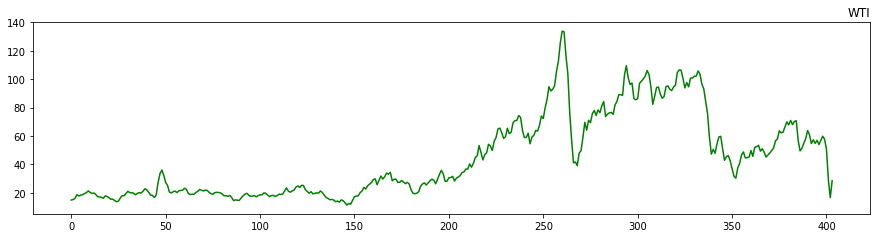

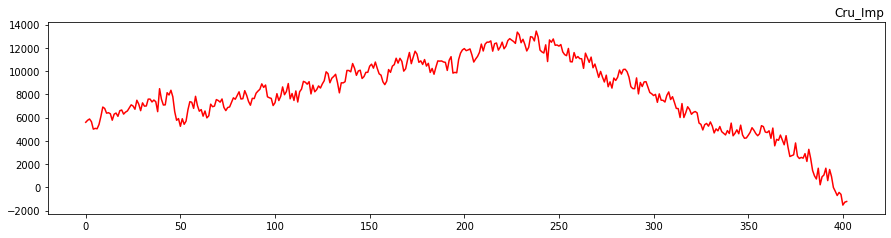

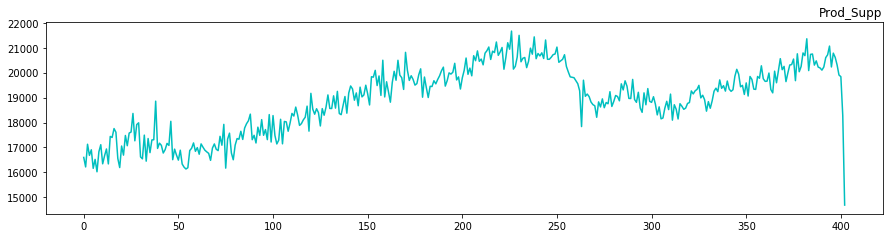

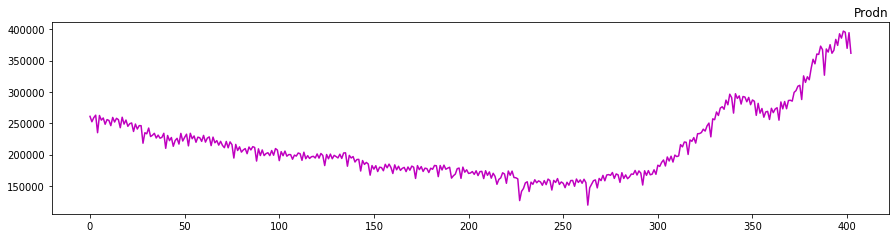

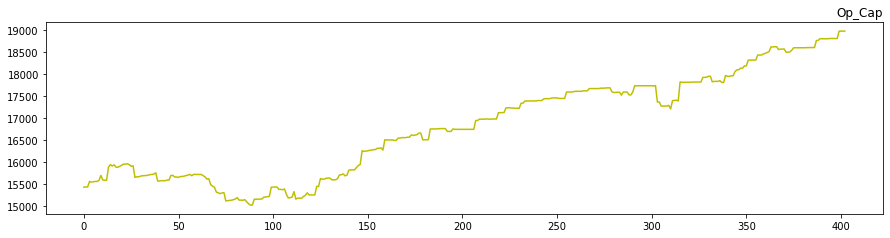

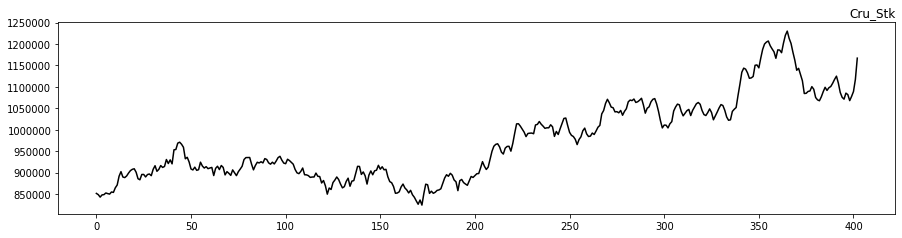

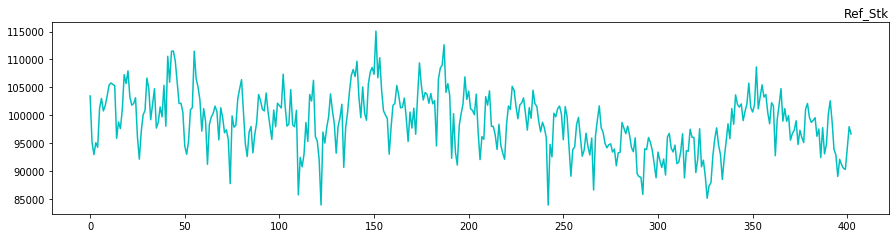

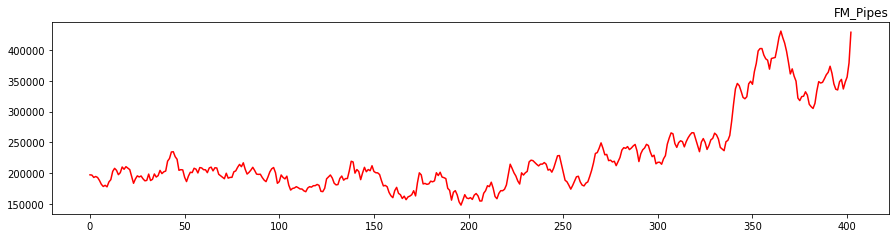

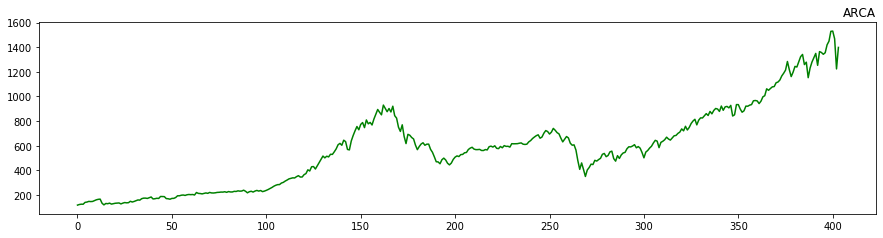

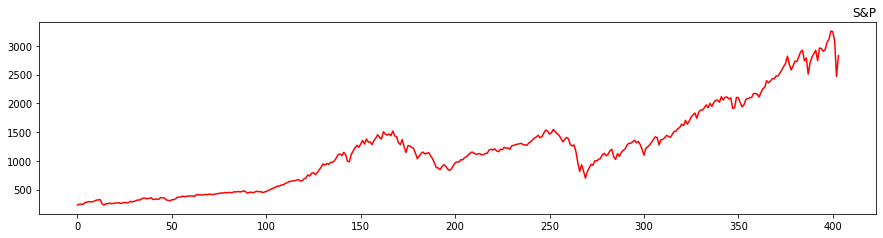

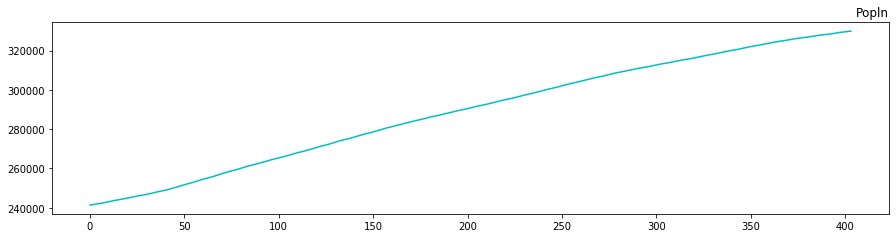

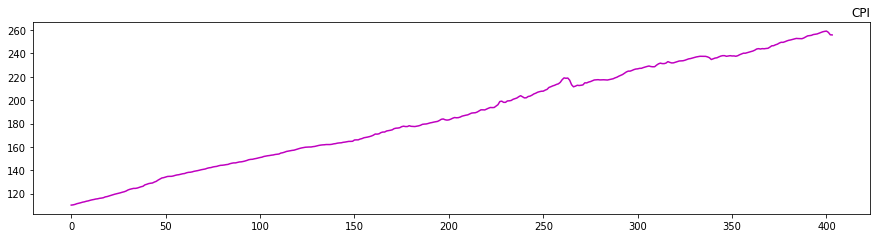

In [3]:
### Descriptive statistics ###

# load dataset
dataset = data_final
values = data_final.values
# specify columns and the color of the plot
groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12]
colors = ['r','g','r','c','m','y','k','c','r','g','r','c','m']
i = 1
# plot each column
for group in groups:
	fig = plt.figure(figsize = (15,50))           
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group], color = colors[i])
	plt.title(dataset.columns[group], y=1, loc='right')
	i += 1
plt.show()

In [4]:
data_final.describe().round(1)

,WTI,Cru_Imp,Prod_Supp,Prodn,Cru_Exp,Op_Cap,Cru_Stk,Ref_Stk,FM_Pipes,ARCA,S&P,Popln,CPI
count,404.0,403.0,403.0,403.0,403.0,403.0,403.0,403.0,403.0,404.0,404.0,404.0,404.0
mean,44.7,7981.7,18917.7,214246.6,322.3,16807.2,973302.9,98752.0,226542.2,578.6,1191.7,288881.7,187.0
std,29.0,3073.8,1348.1,55683.6,691.7,1139.7,94978.9,5254.4,62953.2,326.4,724.1,26961.5,42.9
min,11.4,-1526.0,14691.0,119208.0,2.0,15028.0,824144.0,83895.0,148094.0,117.8,232.0,241371.0,110.2
25%,19.9,6222.0,17940.0,172797.5,34.0,15692.0,895510.0,95050.0,187135.0,243.1,484.1,265564.5,151.1
50%,32.0,8059.0,19095.0,198850.0,89.0,16757.0,935670.0,98881.0,203819.0,575.7,1134.1,290850.0,184.2
75%,63.7,10316.0,19941.0,242575.5,160.5,17688.0,1045037.0,102056.5,241073.0,752.0,1457.0,313104.8,227.4
max,133.9,13442.0,21666.0,397204.0,3708.0,18976.0,1230105.0,115090.0,430638.0,1531.0,3257.9,329894.0,259.0


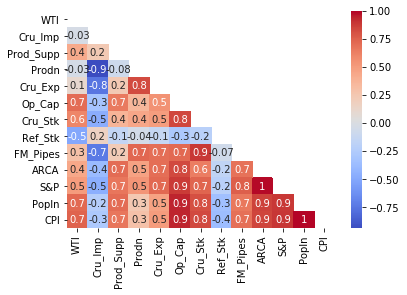

In [5]:
#Correlation heatmap

matrix = np.triu(data_final.corr())
sns.heatmap(data_final.corr(), annot = True, fmt='.1g', cmap= 'coolwarm', mask=matrix)

#Interpretation: financial markets based variables as well as operational capacity and population return high correlation values

In [7]:
#Remove highly correlated variables before proceeding

data_final2 = data_final.loc[:, ['WTI','Cru_Imp','Prod_Supp',
             'Prodn','Cru_Exp',
             'Cru_Stk','Ref_Stk',
             'FM_Pipes','S&P']]
data_final2

,WTI,Cru_Imp,Prod_Supp,Prodn,Cru_Exp,Cru_Stk,Ref_Stk,FM_Pipes,S&P
1986-10,14.90,5597.0,16602.0,260984.0,151.0,851406.0,103461.0,197234.0,233.600006
1986-11,15.22,5771.0,16221.0,252374.0,115.0,848555.0,95217.0,196820.0,245.800003
1986-12,16.11,5881.0,17130.0,258926.0,159.0,842789.0,92954.0,192993.0,249.050003
1987-01,18.65,5650.0,16684.0,262888.0,84.0,847939.0,95077.0,194579.0,246.449997
1987-02,17.75,5007.0,16908.0,234880.0,284.0,848567.0,94262.0,192960.0,276.450012
...,...,...,...,...,...,...,...,...,...
2020-01,57.68,-605.0,19905.0,395391.0,3251.0,1077801.0,90295.0,347821.0,3257.850098
2020-02,50.54,-1526.0,19839.0,369682.0,3708.0,1089192.0,93993.0,356140.0,3248.919922
2020-03,29.21,-1276.0,18284.0,394645.0,3557.0,1117421.0,97956.0,378673.0,3090.229980
2020-04,16.55,-1216.0,14691.0,361831.0,3077.0,1166990.0,96636.0,428752.0,2470.500000


In [8]:
# save pre-processed data to file
data_final2.to_csv('data_final2.csv')
data_final2

,WTI,Cru_Imp,Prod_Supp,Prodn,Cru_Exp,Cru_Stk,Ref_Stk,FM_Pipes,S&P
1986-10,14.90,5597.0,16602.0,260984.0,151.0,851406.0,103461.0,197234.0,233.600006
1986-11,15.22,5771.0,16221.0,252374.0,115.0,848555.0,95217.0,196820.0,245.800003
1986-12,16.11,5881.0,17130.0,258926.0,159.0,842789.0,92954.0,192993.0,249.050003
1987-01,18.65,5650.0,16684.0,262888.0,84.0,847939.0,95077.0,194579.0,246.449997
1987-02,17.75,5007.0,16908.0,234880.0,284.0,848567.0,94262.0,192960.0,276.450012
...,...,...,...,...,...,...,...,...,...
2020-01,57.68,-605.0,19905.0,395391.0,3251.0,1077801.0,90295.0,347821.0,3257.850098
2020-02,50.54,-1526.0,19839.0,369682.0,3708.0,1089192.0,93993.0,356140.0,3248.919922
2020-03,29.21,-1276.0,18284.0,394645.0,3557.0,1117421.0,97956.0,378673.0,3090.229980
2020-04,16.55,-1216.0,14691.0,361831.0,3077.0,1166990.0,96636.0,428752.0,2470.500000


In [9]:
### end of data gathering/pre-processing and descriptive analysis ###

In [10]:
# read csv file
data_final2 = read_csv('data_final2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
data_final2

,WTI,Cru_Imp,Prod_Supp,Prodn,Cru_Exp,Cru_Stk,Ref_Stk,FM_Pipes,S&P
1986-10-01,14.90,5597.0,16602.0,260984.0,151.0,851406.0,103461.0,197234.0,233.600006
1986-11-01,15.22,5771.0,16221.0,252374.0,115.0,848555.0,95217.0,196820.0,245.800003
1986-12-01,16.11,5881.0,17130.0,258926.0,159.0,842789.0,92954.0,192993.0,249.050003
1987-01-01,18.65,5650.0,16684.0,262888.0,84.0,847939.0,95077.0,194579.0,246.449997
1987-02-01,17.75,5007.0,16908.0,234880.0,284.0,848567.0,94262.0,192960.0,276.450012
...,...,...,...,...,...,...,...,...,...
2020-01-01,57.68,-605.0,19905.0,395391.0,3251.0,1077801.0,90295.0,347821.0,3257.850098
2020-02-01,50.54,-1526.0,19839.0,369682.0,3708.0,1089192.0,93993.0,356140.0,3248.919922
2020-03-01,29.21,-1276.0,18284.0,394645.0,3557.0,1117421.0,97956.0,378673.0,3090.229980
2020-04-01,16.55,-1216.0,14691.0,361831.0,3077.0,1166990.0,96636.0,428752.0,2470.500000


In [11]:
### LSTM ###

# Four different LSTM models are being compared in the subsequent section.

# 1. Univariate Multi-Step LSTM
# 2. Univariate Multi-Step Encoder-Decoder LSTM
# 3. Univariate Multi-Step Encoder-Decoder CNN-LSTM
# 4. Multivariate Multi-Step Encoder-Decoder LSTM

In [12]:
# Create a new dataframe that only contains the crude oil price for univariate forecasting
data_final_univariate = data_final2.loc[:, ['WTI']]
#set timeindex for later analysis
time_help = pd.period_range('1986-10', '2020-05', freq ='M')
data_final_univariate.set_index([time_help], inplace = True)
data_final_univariate

,WTI
1986-10,14.90
1986-11,15.22
1986-12,16.11
1987-01,18.65
1987-02,17.75
...,...
2020-01,57.68
2020-02,50.54
2020-03,29.21
2020-04,16.55


In [13]:
#General function which all LSTM models use

#this function divides the dataset into train, test data and changes the dimension into sequences of six months(X, X)
def split_dataset(data):
	# split into standard weeks
	train, test = data[2:356], data[356:404] 
	# restructure into windows of half a year data
	train = array(split(train, len(train)/6))
	test = array(split(test, len(test)/6)) 
	return train, test

# evaluate forecast against expected values
def evaluate_forecasts(actual, predicted):
	actual = actual.reshape((actual.shape[0]*actual.shape[1]))
	predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1]))
	actual = array(split(actual, int(len(actual)/(int(len(actual)/6)))))
	predicted = array(split(predicted, int(len(predicted)/(int(len(predicted)/6)))))
	scores = list()
	# calculate an RMSE score for certain range (depends on the amount of data which is analysed)
	for i in range(actual.shape[0]):
		# calculate mse
		mse = mean_squared_error(actual[i, :], predicted[i, :])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores, actual, predicted

# summarize scores (RMSE values over time)
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# make a forecast (6 months)
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next 6-month
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluates the out-of-sample performance
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of half a year data
	history = [x for x in train]
	# walk-forward validation over each half a year
	predictions = list()
	for i in range(len(test)):
		# predict the next half year
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the half year
		history.append(test[i, :])
	# evaluate predictions months for each half a year
	predictions = array(predictions)
	score, scores, actual, predicted = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions, actual, predicted

# this method is calculating the in-sample performance
def evaluate_model2(train, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of half a year data
	history = [x for x in train]
	# walk-forward validation over each half a year
	predictions2 = list()
	for i in range(len(train)):
		# predict the next six months
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions2.append(yhat_sequence)
		# get real observation and add to history for predicting the next six months
		history.append(train[i, :])
	# evaluate predictions month for each six month
	predictions2 = array(predictions2)
	score2, scores2, actual, predicted = evaluate_forecasts(train[:, :, 0], predictions2)
	return score2, scores2, predictions2

RMSE Score Out-of-Sample: [13.562] 5.4, 6.0, 2.7, 12.9, 10.1, 27.6


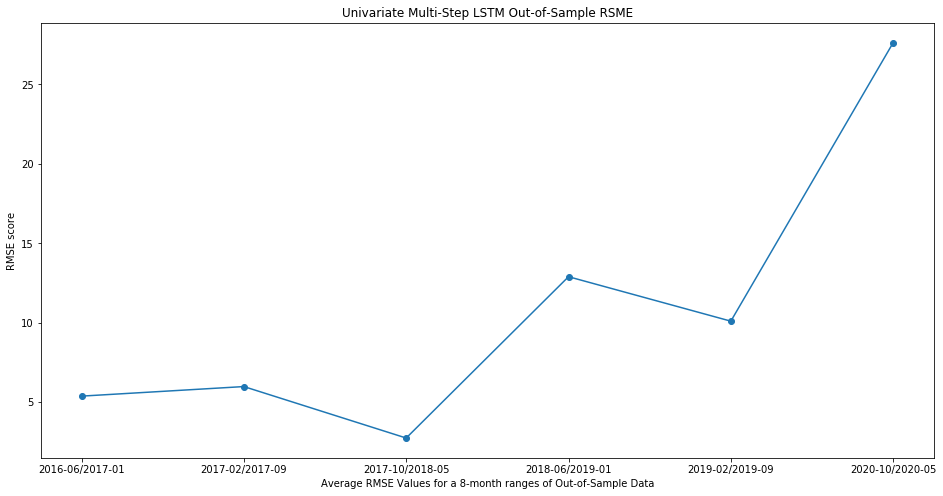

RMSE Score In-Sample: [8.109] 10.0, 1.7, 3.5, 6.7, 11.5, 10.2


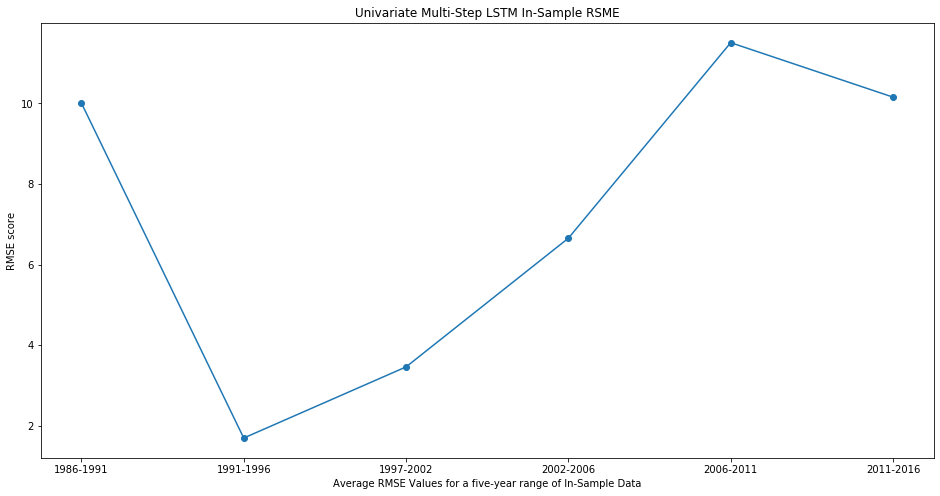

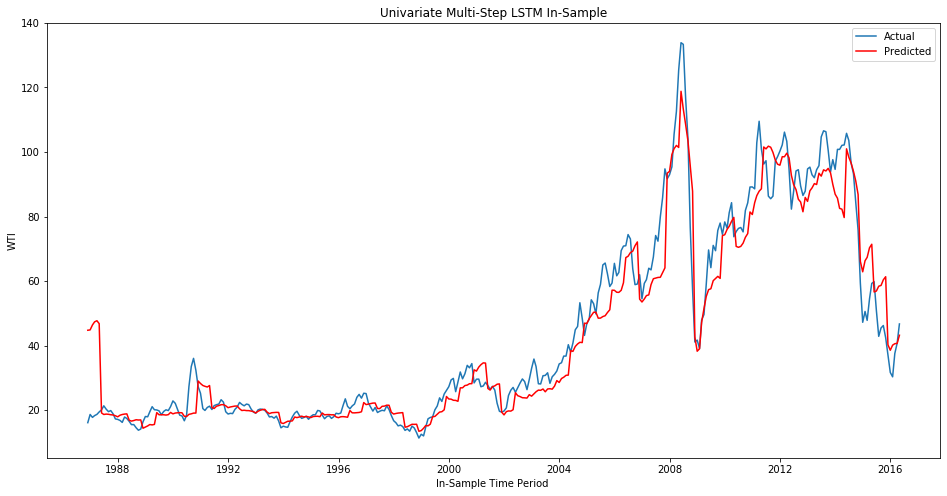

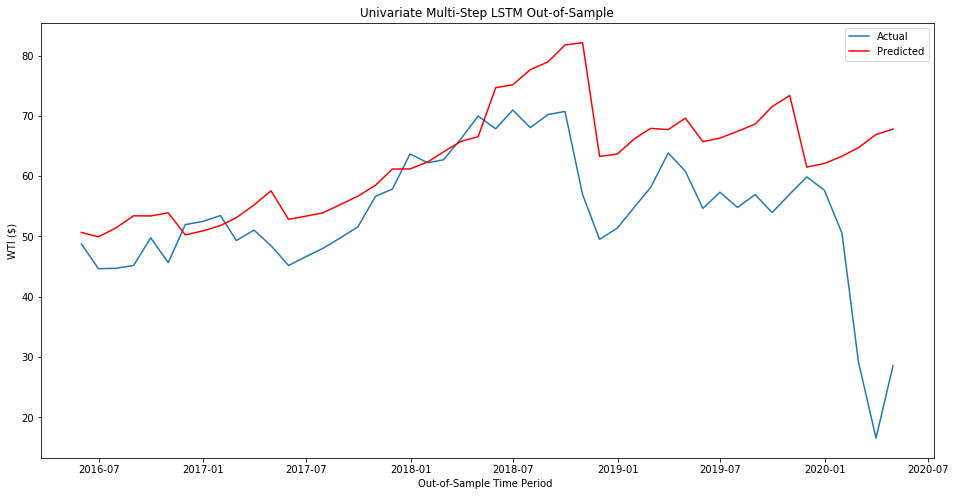

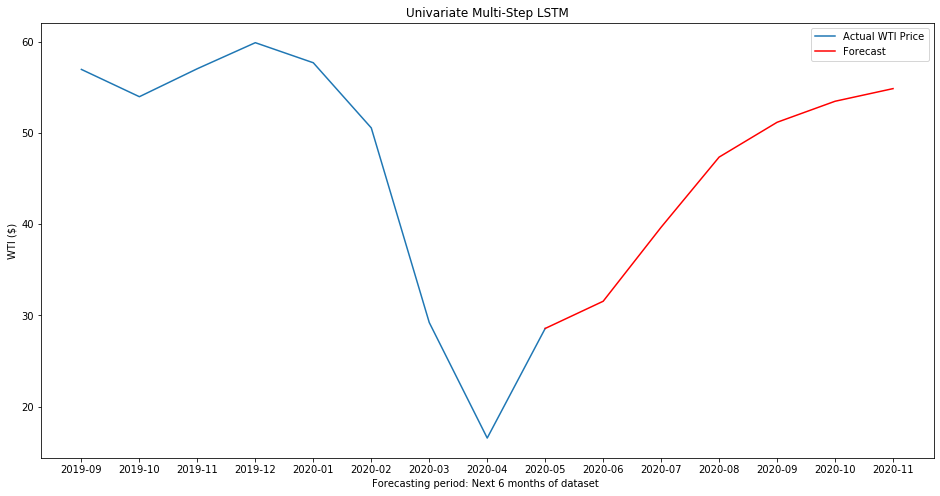

In [14]:
# 1. Simple univariate Multi-Step LSTM #

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 150, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(64, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model


#load the dataset
dataset = data_final_univariate
train, test = split_dataset(dataset.values)
# evaluate model and get scores, define input sequence (our model always six months)
n_input = 6
score, scores, predictions, actual, predicted = evaluate_model(train, test, n_input)
score2, scores2, predictions2 = evaluate_model2(train, n_input)

# store performance indataframes for plot in which all models are shown at the end
RMSE_Out_UnivariatesLSTM = score
RMSE_In_UnivariatesLSTM = score2

# summarize scores for out-of-sample
summarize_scores('RMSE Score Out-of-Sample', score, scores)

# plot scores Out-of-Sample
fig = plt.figure(figsize = (16,8))
periods = ['2016-06/2017-01','2017-02/2017-09','2017-10/2018-05','2018-06/2019-01','2019-02/2019-09','2020-10/2020-05']
pyplot.plot(periods, scores, marker='o', label='LSTM RMSE')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a 8-month ranges of Out-of-Sample Data')
plt.title('Univariate Multi-Step LSTM Out-of-Sample RSME')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 8-months within the test
#               data, it helps to identify time ranges where the model performing especially good or bad


# summarize scores for in-sample
summarize_scores('RMSE Score In-Sample', score2, scores2)

#plot scores In-Sample
fig = plt.figure(figsize = (16,8))
periods = ['1986-1991','1991-1996','1997-2002','2002-2006','2006-2011','2011-2016']
pyplot.plot(periods, scores2, marker='o', label='LSTM RSME')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a five-year range of In-Sample Data')
plt.title('Univariate Multi-Step LSTM In-Sample RSME')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 5-years within the train
#               data, helps to identify time ranges where the model is especially good or bad

#build six month prediction from june'20 ongoing for six months
model = build_model(train, n_input)
data_total2 = dataset[2:404]
data_total2 = array(split(data_total2.values, len(data_total2)/6))
history = [x for x in data_total2]
y_hat = forecast(model, history, n_input)
y_hat = np.append([28.56],y_hat)

#plot Forecast and real WTI Price for In-Sample Data
data_plot = dataset[2:356]
predictions2 = predictions2.reshape(predictions2.shape[0]* predictions2.shape[1])
predictions_df = pd.DataFrame(predictions2, columns = ['Prediction_0'])
# help index for In-Sample Data
start = datetime.datetime(1986, 11, 1)
end = datetime.datetime(2016, 5, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df.set_index([index], inplace = True)
predictions_univariatesLSTM_IN = predictions_df
data_plot.set_index([index], inplace = True)
df = pd.concat((data_plot, predictions_df), axis = 1)
# plot In-Sample FC and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_0'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI')
plt.xlabel('In-Sample Time Period ')
plt.title('Univariate Multi-Step LSTM In-Sample')
plt.show()

#plot all predictions with true value
data_plot = dataset[356:404]
predictions = predictions.reshape(predictions.shape[0]* predictions.shape[1])
predictions_df2 = pd.DataFrame(predictions, columns = ['Prediction_0'])
# help index for Out-of-sample Data
start = datetime.datetime(2016, 5, 1)
end = datetime.datetime(2020, 5, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df2.set_index([index], inplace = True)
predictions_univariatesLSTM_Out = predictions_df2
data_plot.set_index([index], inplace = True)
df = pd.concat((data_plot, predictions_df2), axis = 1)
# plot Out-of-Sample forecast and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_0'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('Out-of-Sample Time Period ')
plt.title('Univariate Multi-Step LSTM Out-of-Sample')
plt.show()

# plot forecast scores for the next 6 months
dates = np.asarray(pd.date_range('2020-04', '2020-11', freq = 'M'))
df_FC = pd.DataFrame(y_hat, index = dates, columns = ['Prediction'])
# help index for the next 6 months
time_help = pd.period_range('2020-05', '2020-11', freq ='M')
df_FC.set_index([time_help], inplace = True)
df_FCfinal = pd.concat((data_final_univariate, df_FC), axis = 1)
df_FCfinal.index = df_FCfinal.index.to_timestamp('s').strftime('%Y-%m')
df_new = df_FCfinal.iloc[395:410]
# plot six month Forecast with last WTI prices
fig = plt.figure(figsize = (16,8))
plt.plot(df_new.index, df_new['WTI'], label = 'Actual WTI Price')
plt.plot(df_new.index, df_new['Prediction'], color ='r', label = 'Forecast')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('Forecasting period: Next 6 months of dataset ')
plt.title('Univariate Multi-Step LSTM')
plt.show()

RMSE Score Out-of-Sample: [11.061] 3.6, 3.5, 5.7, 8.9, 5.8, 23.7


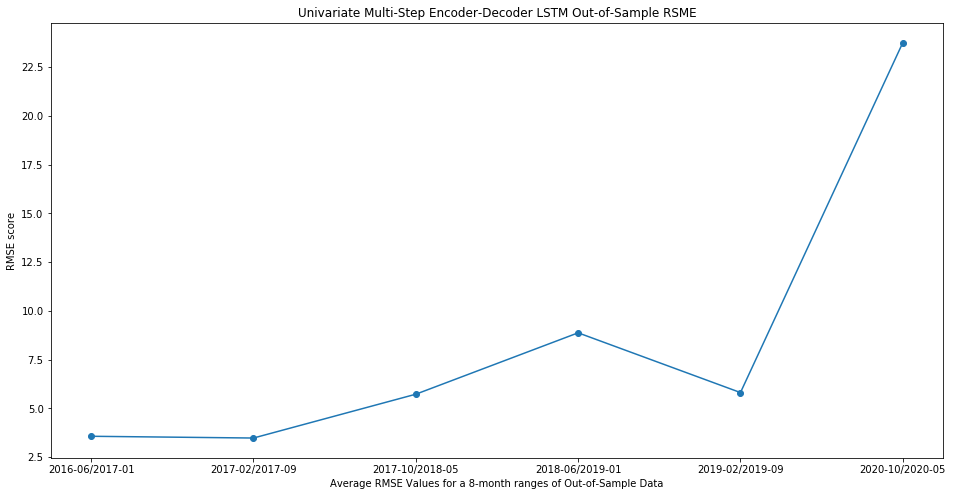

RMSE Score In-Sample: [8.408] 10.8, 2.3, 4.2, 4.3, 12.3, 10.7


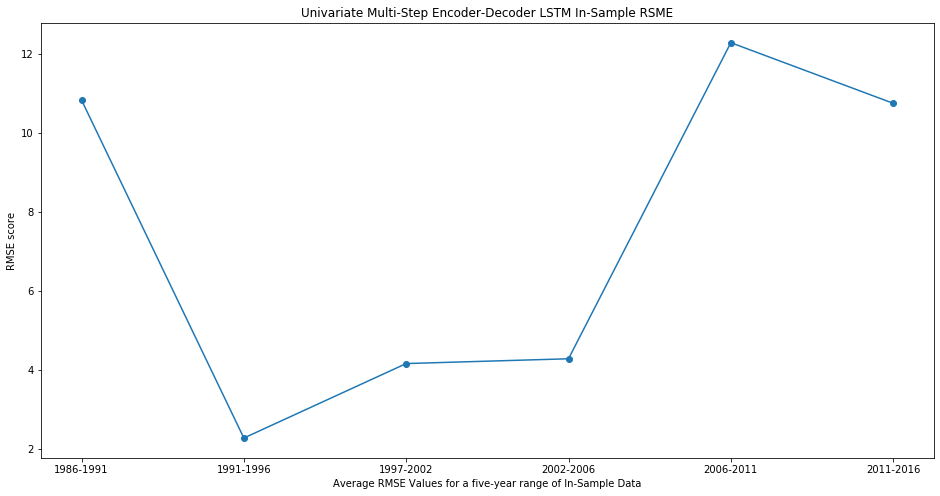

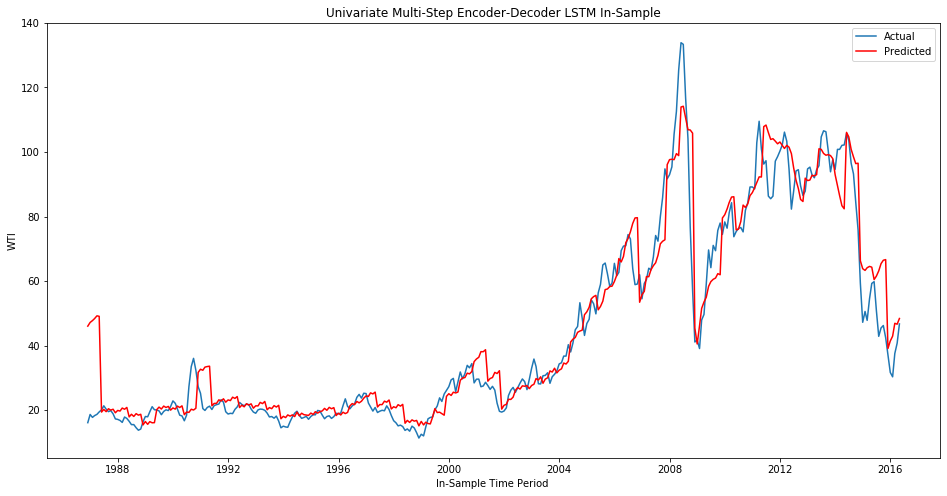

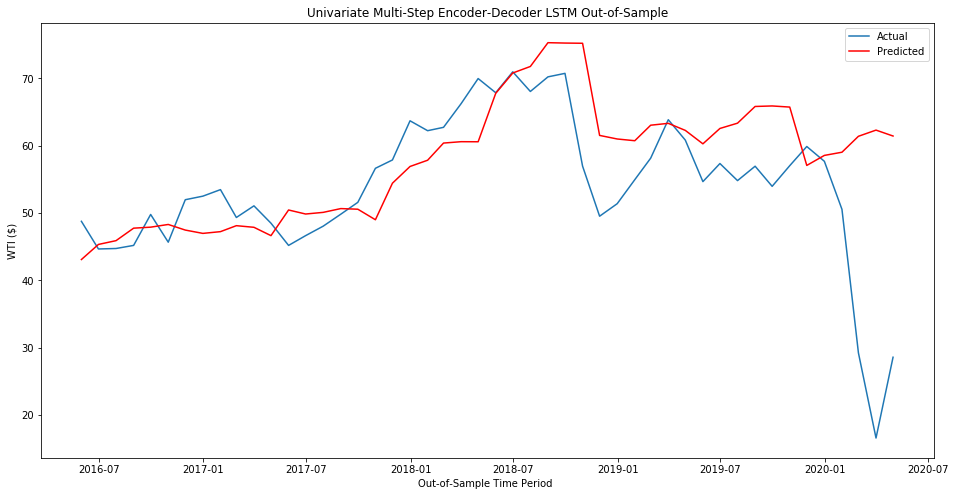

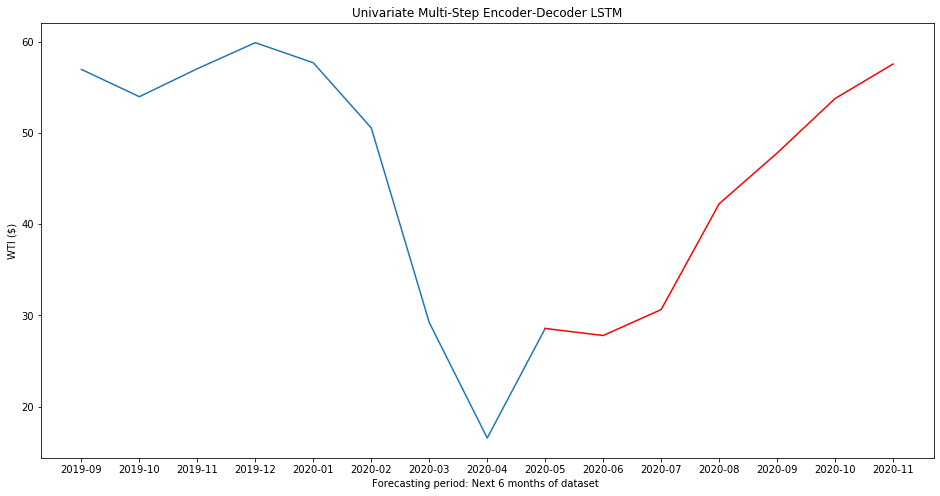

In [15]:
# 2. Univariate Multi-Step Encoder-Decoder LSTM # 


# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 48
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(32, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(16, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

#load the dataset
dataset = data_final_univariate
train, test = split_dataset(dataset.values)
# evaluate model and get scores, define input sequence (our model always six months)
score, scores, predictions, actual, predicted = evaluate_model(train, test, n_input)
score2, scores2, predictions2 = evaluate_model2(train, n_input)

# store performance for plot where all models are shown
RMSE_Out_UnivariatesEncDecLSTM = score
RMSE_In_UnivariatesEncDecLSTM = score2

# summarize scores for out-of-sample
summarize_scores('RMSE Score Out-of-Sample', score, scores)

# plot RMSE scores Out-of-Sample
fig = plt.figure(figsize = (16,8))
periods = ['2016-06/2017-01','2017-02/2017-09','2017-10/2018-05','2018-06/2019-01','2019-02/2019-09','2020-10/2020-05']
pyplot.plot(periods, scores, marker='o', label='lstm')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a 8-month ranges of Out-of-Sample Data')
plt.title('Univariate Multi-Step Encoder-Decoder LSTM Out-of-Sample RSME')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 8-months within the test
#               data, helps to identify time ranges where the model is especially good or bad

# summarize scores for in-sample
summarize_scores('RMSE Score In-Sample', score2, scores2)

#plot RMSE scores In-Sample
fig = plt.figure(figsize = (16,8))
periods = ['1986-1991','1991-1996','1997-2002','2002-2006','2006-2011','2011-2016']
pyplot.plot(periods, scores2, marker='o', label='lstm')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a five-year range of In-Sample Data')
plt.title('Univariate Multi-Step Encoder-Decoder LSTM In-Sample RSME')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 5-years within the train
#               data, helps to identify time ranges where the model is especially good or bad

#build six month prediction from june'20 ongoing for six months
model = build_model(train, n_input)
data_total2 = dataset[2:404]
data_total2 = array(split(data_total2.values, len(data_total2)/6))
history = [x for x in data_total2]
y_hat = forecast(model, history, n_input)
y_hat = np.append([28.56],y_hat)

#plot all in-sample predictions with true value
data_plot = dataset[2:356]
predictions2 = predictions2.reshape(predictions2.shape[0]* predictions2.shape[1])
predictions_df = pd.DataFrame(predictions2, columns = ['Prediction_1'])
# help index for In-sample Data
start = datetime.datetime(1986, 11, 1)
end = datetime.datetime(2016, 5, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df.set_index([index], inplace = True)
predictions_univariatesEncDecLSTM_In = predictions_df
data_plot.set_index([index], inplace = True)
data_plot_help = data_plot
df = pd.concat((data_plot, predictions_df), axis = 1)
# plot In-Sample Forecast and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_1'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI')
plt.xlabel('In-Sample Time Period ')
plt.title('Univariate Multi-Step Encoder-Decoder LSTM In-Sample')
plt.show()

#plot all out-of-sample predictions with true value
data_plot = dataset[356:404]
predictions = predictions.reshape(predictions.shape[0]* predictions.shape[1])
predictions_df2 = pd.DataFrame(predictions, columns = ['Prediction_1'])
# help index for Out-of-sample Data
start = datetime.datetime(2016, 5, 1)
end = datetime.datetime(2020, 5, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df2.set_index([index], inplace = True)
predictions_univariatesEncDecLSTM_Out = predictions_df2
data_plot.set_index([index], inplace = True)
data_plot_help2 = data_plot
df = pd.concat((data_plot, predictions_df2), axis = 1)
# plot Out-of-Sample Forecast and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_1'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('Out-of-Sample Time Period ')
plt.title('Univariate Multi-Step Encoder-Decoder LSTM Out-of-Sample')
plt.show()

# plot forecast scores for the next 6 months
dates = np.asarray(pd.date_range('2020-04', '2020-11', freq = 'M'))
df_FC = pd.DataFrame(y_hat, index = dates, columns = ['Prediction'])
# help index for the next 6 months
time_help = pd.period_range('2020-05', '2020-11', freq ='M')
df_FC.set_index([time_help], inplace = True)
df_FCfinal = pd.concat((data_final_univariate, df_FC), axis = 1)
df_FCfinal.index = df_FCfinal.index.to_timestamp('s').strftime('%Y-%m')
df_new = df_FCfinal.iloc[395:410]
# plot six month Forecast with last WTI prices
fig = plt.figure(figsize = (16,8))
plt.plot(df_new.index, df_new['WTI'])
plt.plot(df_new.index, df_new['Prediction'], color ='r')
plt.ylabel('WTI ($)')
plt.xlabel('Forecasting period: Next 6 months of dataset ')
plt.title('Univariate Multi-Step Encoder-Decoder LSTM')
plt.show()


RMSE Score Out-of-Sample: [11.786] 2.3, 4.8, 5.3, 11.6, 11.5, 22.6


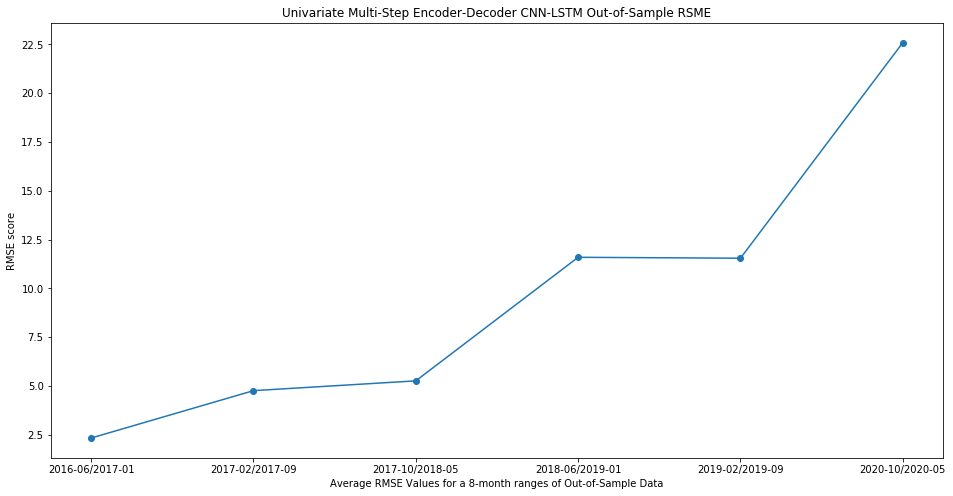

RMSE Score In-Sample: [9.327] 10.7, 1.9, 3.4, 6.3, 13.0, 13.6


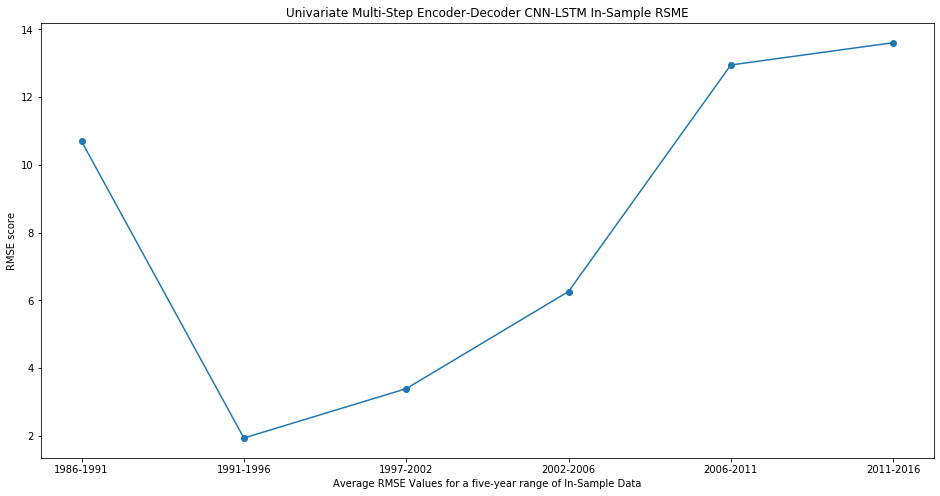

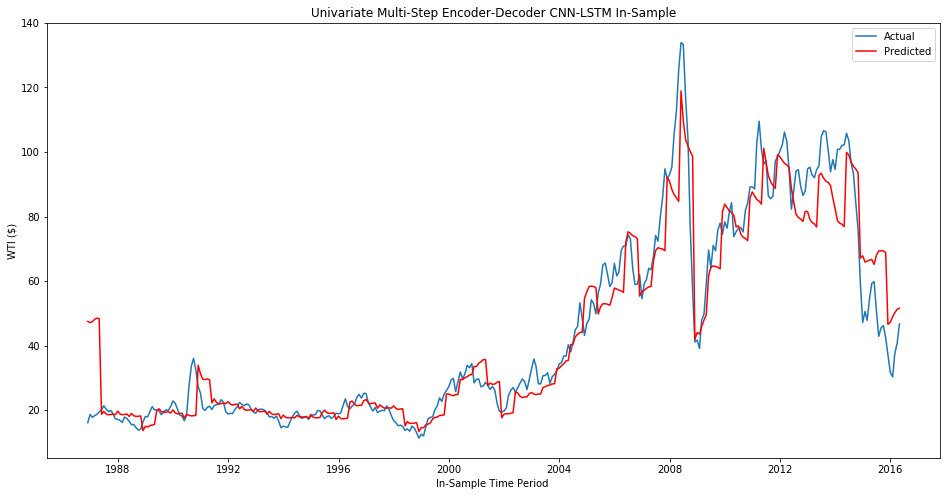

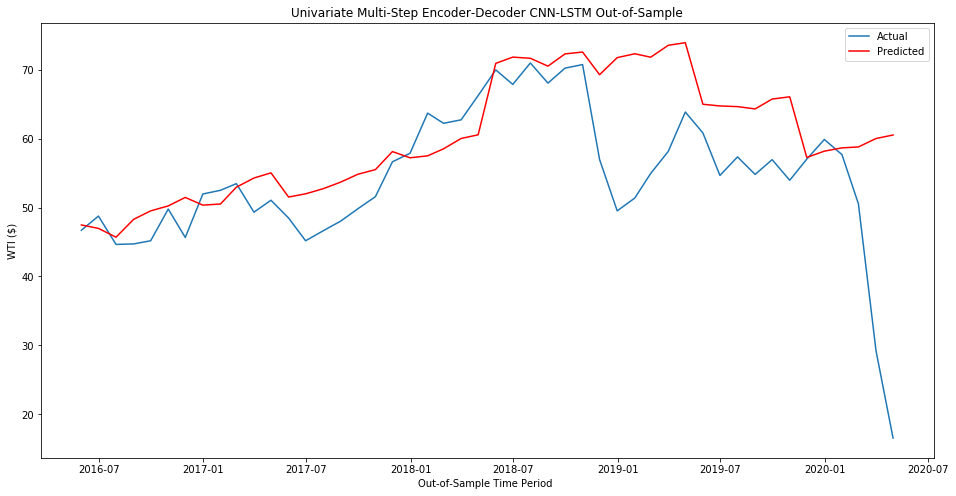

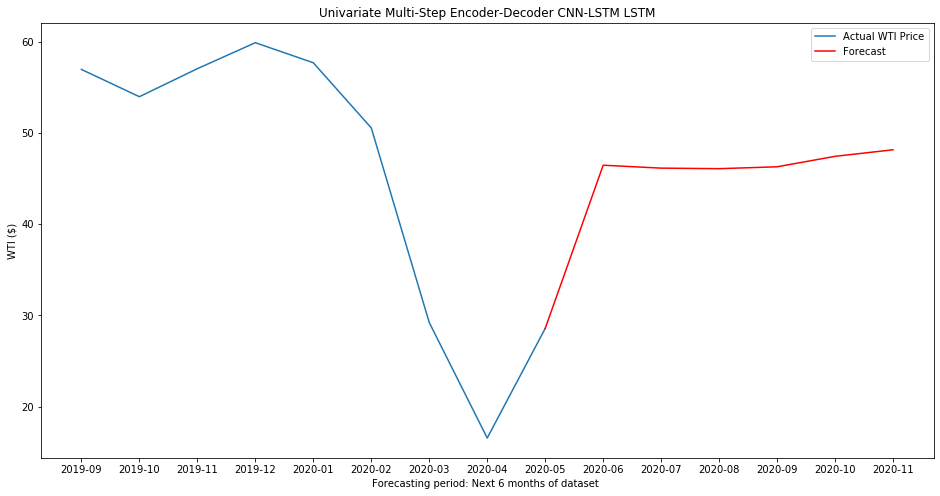

In [16]:
# 3. Univariate Multi-Step Encoder-Decoder CNN-LSTM # 


# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 8
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(128, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(64, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

#load dataset
dataset = data_final_univariate
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 6
score, scores, predictions, actual, predicted = evaluate_model(train, test, n_input)
score2, scores2, predictions2 = evaluate_model2(train, n_input)

# store performance for plot where all models are shown
RMSE_Out_UnivariatesEncDecCNNLSTM = score
RMSE_In_UnivariatesEncDecCNNLSTM = score2

# summarize scores of Out-of-sample data
summarize_scores('RMSE Score Out-of-Sample', score, scores)

# plot scores In-Sample
fig = plt.figure(figsize = (16,8))
periods = ['2016-06/2017-01','2017-02/2017-09','2017-10/2018-05','2018-06/2019-01','2019-02/2019-09','2020-10/2020-05']
pyplot.plot(periods, scores, marker='o', label='lstm')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a 8-month ranges of Out-of-Sample Data')
plt.title('Univariate Multi-Step Encoder-Decoder CNN-LSTM Out-of-Sample RSME')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 8-months within the test
#               data, helps to identify time ranges where the model is especially good or bad

# summarize scores of In-sample data
summarize_scores('RMSE Score In-Sample', score2, scores2)

#plot scores Out-Of-Sample
fig = plt.figure(figsize = (16,8))
periods = ['1986-1991','1991-1996','1997-2002','2002-2006','2006-2011','2011-2016']
pyplot.plot(periods, scores2, marker='o', label='lstm')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a five-year range of In-Sample Data')
plt.title('Univariate Multi-Step Encoder-Decoder CNN-LSTM In-Sample RSME')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 5-years within the train
#               data, helps to identify time ranges where the model is especially good or bad

#build six month prediction from june'20 ongoing for six months
model = build_model(train, n_input)
data_total2 = dataset[2:356]
data_total2 = array(split(data_total2.values, len(data_total2)/6))
history = [x for x in data_total2]
y_hat = forecast(model, history, n_input)
y_hat = np.append([28.56],y_hat)

#bring In-Sample True and Predicted Values into one DataFrame
data_plot = dataset[2:356]
predictions2 = predictions2.reshape(predictions2.shape[0]* predictions2.shape[1])
predictions_df = pd.DataFrame(predictions2, columns = ['Prediction_2'])
# help index for in-sample data
start = datetime.datetime(1986, 11, 1)
end = datetime.datetime(2016, 5, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df.set_index([index], inplace = True)
predictions_univariatesEncDecCNNLSTM_In = predictions_df
data_plot.set_index([index], inplace = True)
df = pd.concat((data_plot, predictions_df), axis = 1)
# plot In-Sample FC and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_2'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('In-Sample Time Period ')
plt.title('Univariate Multi-Step Encoder-Decoder CNN-LSTM In-Sample')
plt.show()

#bring Out-of-Sample True and Predicted Values into one DataFrame
data_plot = dataset[355:403]
predictions = predictions.reshape(predictions.shape[0]* predictions.shape[1])
predictions_df2 = pd.DataFrame(predictions, columns = ['Prediction_2'])
# help index for out-of-sample data
start = datetime.datetime(2016, 5, 1)
end = datetime.datetime(2020, 5, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df2.set_index([index], inplace = True)
predictions_univariatesEncDecCNNLSTM_Out = predictions_df2
data_plot.set_index([index], inplace = True)
df = pd.concat((data_plot, predictions_df2), axis = 1)
# plot Out-of-Sample FC and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_2'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('Out-of-Sample Time Period ')
plt.title('Univariate Multi-Step Encoder-Decoder CNN-LSTM Out-of-Sample')
plt.show()

# plot forecast scores for the next 6 months
dates = np.asarray(pd.date_range('2020-04', '2020-11', freq = 'M'))
df_FC = pd.DataFrame(y_hat, index = dates, columns = ['Prediction'])
time_help = pd.period_range('2020-05', '2020-11', freq ='M')
df_FC.set_index([time_help], inplace = True)
df_FCfinal = pd.concat((data_final_univariate, df_FC), axis = 1)
df_FCfinal.index = df_FCfinal.index.to_timestamp('s').strftime('%Y-%m')
df_new = df_FCfinal.iloc[395:410]
# plot six month Forecast with last WTI prices
fig = plt.figure(figsize = (16,8))
plt.plot(df_new.index, df_new['WTI'], label = 'Actual WTI Price')
plt.plot(df_new.index, df_new['Prediction'], color ='r', label = 'Forecast')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('Forecasting period: Next 6 months of dataset ')
plt.title('Univariate Multi-Step Encoder-Decoder CNN-LSTM LSTM')
plt.show()


In [17]:
# Drop any NaN values left in dataframe
data_final2.dropna(how='any', inplace=True)
# ensure dataset is numeric
data_final2 = data_final2.astype('float32')
data_final2

,WTI,Cru_Imp,Prod_Supp,Prodn,Cru_Exp,Cru_Stk,Ref_Stk,FM_Pipes,S&P
1986-10-01,14.900000,5597.0,16602.0,260984.0,151.0,851406.0,103461.0,197234.0,233.600006
1986-11-01,15.220000,5771.0,16221.0,252374.0,115.0,848555.0,95217.0,196820.0,245.800003
1986-12-01,16.110001,5881.0,17130.0,258926.0,159.0,842789.0,92954.0,192993.0,249.050003
1987-01-01,18.650000,5650.0,16684.0,262888.0,84.0,847939.0,95077.0,194579.0,246.449997
1987-02-01,17.750000,5007.0,16908.0,234880.0,284.0,848567.0,94262.0,192960.0,276.450012
...,...,...,...,...,...,...,...,...,...
2019-12-01,59.880001,-435.0,20312.0,397204.0,3669.0,1067904.0,90495.0,336658.0,3113.870117
2020-01-01,57.680000,-605.0,19905.0,395391.0,3251.0,1077801.0,90295.0,347821.0,3257.850098
2020-02-01,50.540001,-1526.0,19839.0,369682.0,3708.0,1089192.0,93993.0,356140.0,3248.919922
2020-03-01,29.209999,-1276.0,18284.0,394645.0,3557.0,1117421.0,97956.0,378673.0,3090.229980


RMSE Score Out-of-Sample: [43.431] 4.6, 7.2, 23.7, 40.1, 55.7, 77.3


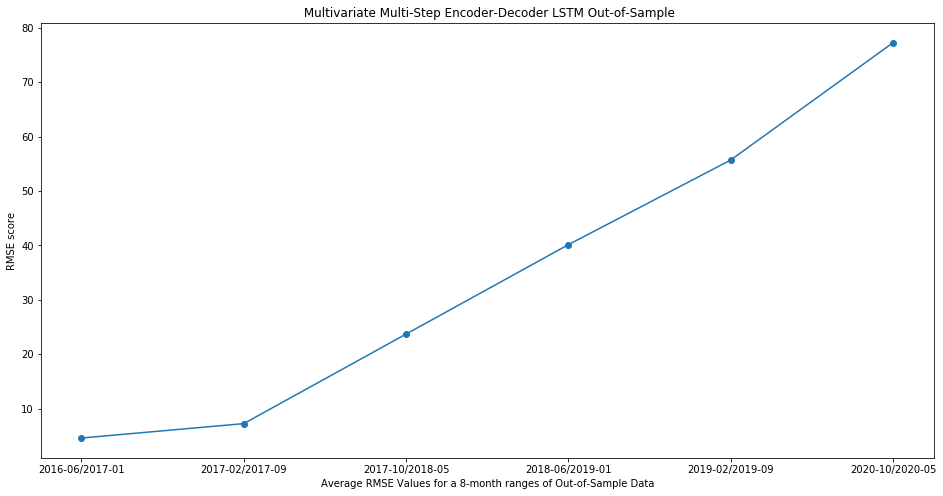

RMSE Score In-Sample: [6.987] 8.3, 2.8, 3.4, 3.9, 10.6, 8.7


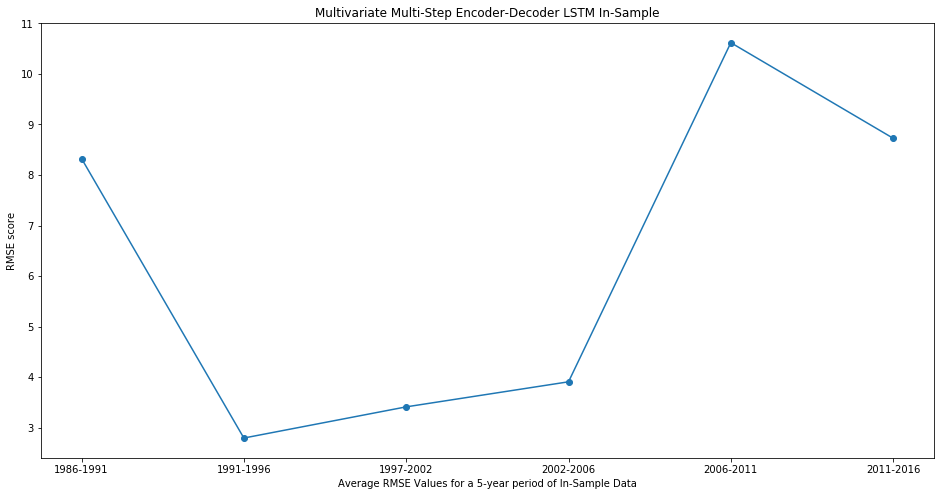

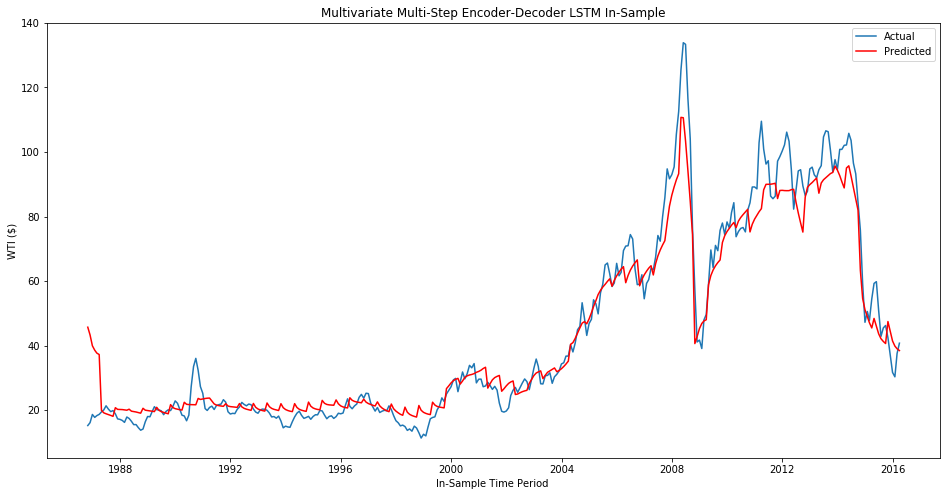

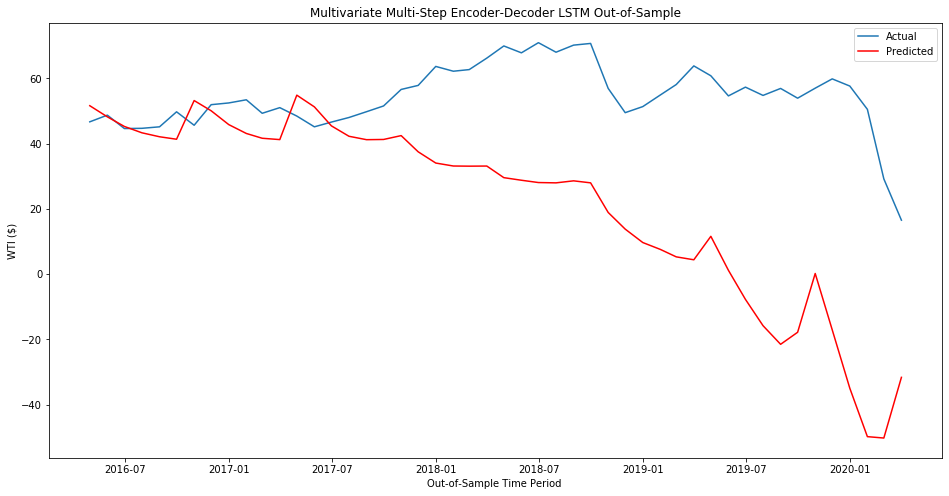

In [18]:
# 4. Multivariate Multi-Step Encoder-Decoder LSTM with normalisation # 


def split_dataset(data):
	# split into six month sequences
	train, test = data[1:355], data[355:403] 
	# restructure into windows of six months
	train = array(split(train, len(train)/6))
	test = array(split(test, len(test)/6)) 
	return train, test

    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			#here we include all 9 features instead of only one            
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 192, 48
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(Dropout(0.4))
	model.add(LSTM(64, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(32, activation='relu')))
	model.add(Dropout(0.4))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast, including all 9 variables
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data, we include all 9 features here
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next six-month
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate the model for the out-of-sample data, can not use the function for the others due to normalisation of data
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of six month data
	history = [x for x in train]
	# walk-forward validation over each month
	predictions = list()
	for i in range(len(test)):
		# predict the six months
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# since out data is normalised, we have to inverse the data by putting it back into the [X, 9] shape 
	predictions = array(predictions)
	predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2]) 
	test1 = test.reshape(test.shape[0] * test.shape[1], test.shape[2])
	test1 = test1[:,1:]
	inv_yhat = np.concatenate((predictions, test1), axis = 1)
	# DataFrame is now in the right dimension to inverse it
	inv_yhat = scaler.inverse_transform(inv_yhat)
	inv_yhat = inv_yhat[:,0]   
	inv_yhat = array(split(inv_yhat, len(inv_yhat)/6))
	# other variables are excluded, so we come to the [X, X, 1] dimension where only predicted values for WTI are included 
	predictions = inv_yhat
	test_new = values[355:403]
	test_new = array(split(test_new, len(test_new)/6))
	# evaluate predictions months for the six month
	score, scores, actual, predicted = evaluate_forecasts(test_new[:, :, 0], predictions)
	return score, scores, predictions, actual, predicted

# evaluate the model for the in-sample data, can not use the function predefined for the other LSTM models due to normalisation of data
def evaluate_model2(train, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions2 = list()
	for i in range(len(train)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions2.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(train[i, :])
	# since out data is normalised, we have to inverse the data by putting it back into the [X, 9] shape 
	predictions2 = array(predictions2)
	predictions2 = predictions2.reshape(predictions2.shape[0] * predictions2.shape[1], predictions2.shape[2]) 
	train1 = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
	train1 = train1[:,1:]
	inv_yhat = np.concatenate ((predictions2, train1), axis = 1)
	# DataFrame is now in the right dimension to invert it
	inv_yhat = scaler.inverse_transform(inv_yhat)
	inv_yhat = inv_yhat[:,0]   
	inv_yhat = array(split(inv_yhat, len(inv_yhat)/6))
	# other variables are excluded, so we come to the [X, X, 1] dimension where only predicted values for WTI are included
	predictions2 = inv_yhat
	train_new = values[1:355]
	train_new = array(split(train_new, len(train_new)/6))
	# evaluate predictions days for each week
	score2, scores2, actual, predicted = evaluate_forecasts(train_new[:, :, 0], predictions2)
	return score2, scores2, predictions2

#load dataset, this time we use the full dataset after exluding correlated variables
dataset = data_final2
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features in a range between 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# split into train and test
train, test = split_dataset(scaled)

# evaluate model and get scores
n_input = 6
score, scores, predictions, actual, predicted = evaluate_model(train, test, n_input)
score2, scores2, predictions2 = evaluate_model2(train, n_input)

# store performance for plot where all models are shown
RMSE_Out_MultivariatesEncDecLSTM = score
RMSE_In_MultivariatesEncDecLSTM= score2

# summarize scores for out-of-sample
summarize_scores('RMSE Score Out-of-Sample', score, scores)

# plot scores Out-of-Sample
fig = plt.figure(figsize = (16,8))
periods = ['2016-06/2017-01','2017-02/2017-09','2017-10/2018-05','2018-06/2019-01','2019-02/2019-09','2020-10/2020-05']
pyplot.plot(periods, scores, marker='o', label='lstm')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a 8-month ranges of Out-of-Sample Data')
plt.title(' Multivariate Multi-Step Encoder-Decoder LSTM Out-of-Sample')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 8-months within the test
#               data, helps to identify time ranges where the model is especially good or bad

# summarize scores for in-sample
summarize_scores('RMSE Score In-Sample', score2, scores2)

#plot scores In-Sample
fig = plt.figure(figsize = (16,8))
periods = ['1986-1991','1991-1996','1997-2002','2002-2006','2006-2011','2011-2016']
pyplot.plot(periods, scores2, marker='o', label='lstm')
plt.ylabel('RMSE score')
plt.xlabel('Average RMSE Values for a 5-year period of In-Sample Data')
plt.title('Multivariate Multi-Step Encoder-Decoder LSTM In-Sample')
pyplot.show()
#Interpretation: This plot shows the average RMSE values for a range of 5-years within the train
#               data, helps to identify time ranges where the model is especially good or bad


#bring In-Sample True and Predicted Values into one DataFrame
predictions2 = predictions2.reshape(predictions2.shape[0]* predictions2.shape[1], 1)
data_help = dataset[1:355] # used for the plot diagram
inv_pred = predictions2[:,0]
predictions_df = pd.DataFrame(inv_pred, columns = ['Prediction_3'])
# help index for in-sample data
start = datetime.datetime(1986, 10, 1)
end = datetime.datetime(2016, 4, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df.set_index([index], inplace = True)
predictions_multivariatesEncDecLSTM_In = predictions_df
data_help.set_index([index], inplace = True)
df = pd.concat((data_help['WTI'], predictions_df), axis = 1)
# plot In-Sample FC and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_3'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('In-Sample Time Period ')
plt.title('Multivariate Multi-Step Encoder-Decoder LSTM In-Sample')
plt.show()

#bring Out-of-Sample True and Predicted Values into one DataFrame
data_plot = dataset[355:403]
predictions = predictions.reshape(predictions.shape[0 ]* predictions.shape[1])
predictions_df2 = pd.DataFrame(predictions, columns = ['Prediction_3'])
# help index for out-of-sample data
start = datetime.datetime(2016, 4, 1)
end = datetime.datetime(2020, 4, 1)
index = pd.date_range(start, end, freq ='M')
predictions_df2.set_index([index], inplace = True)
predictions_multivariatesEncDecLSTM_Out = predictions_df2
data_plot.set_index([index], inplace = True)
df = pd.concat((data_plot, predictions_df2), axis = 1)
# plot Out-of-Sample FC and real WTI price
fig = plt.figure(figsize = (16,8))
plt.plot(df.index, df['WTI'], label ='Actual')
plt.plot(df.index, df['Prediction_3'], color ='r', label = 'Predicted')
plt.legend()
plt.ylabel('WTI ($)')
plt.xlabel('Out-of-Sample Time Period ')
plt.title('Multivariate Multi-Step Encoder-Decoder LSTM Out-of-Sample')
plt.show()

In [19]:
# Compare LSTM models with a simple ARIMA forecasting model #

In [20]:
#prepare univariate dataset for ARIMA modelling

#convert period-based index to datetime-based index

#Create a new dataframe containing the dates
pidx = pd.period_range('1986-10', periods=404, freq='M')
pidx2 = pidx.to_timestamp(freq='M')

#Switch indices 
data_final_univariate.index = pidx2

# Drop any NaN values left in dataframe
data_final_univariate.dropna(how='any', inplace=True)

# ensure dataset is numeric
data_final_univarte = data_final_univariate.astype('float32')

#Print updated dataframe
data_final_univariate

,WTI
1986-10-31,14.90
1986-11-30,15.22
1986-12-31,16.11
1987-01-31,18.65
1987-02-28,17.75
...,...
2020-01-31,57.68
2020-02-29,50.54
2020-03-31,29.21
2020-04-30,16.55


ADF Statistic of original series: -2.434549
p-value of original series: 0.132222
ADF Statistic of differenced series: -9.480869
p-value of differenced series: 0.000000


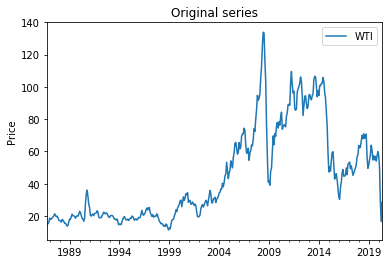

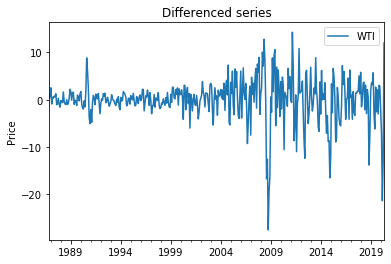

In [21]:
# configure ARIMA model (p,d,q) manually

# find d value

# Original Series
ax = data_final_univariate.plot()
ax.set_ylabel("Price")
ax.set_title("Original series")

# 1st Differencing
ax2 = data_final_univariate.diff().dropna().plot()
ax2.set_ylabel("Price")
ax2.set_title("Differenced series")
data_final_univariate_differenced = data_final_univariate.diff().dropna() #build new dataframe

#Calculate ADF values for both series
result_original = adfuller(data_final_univariate)
result_differenced = adfuller(data_final_univariate.diff().dropna())

print('ADF Statistic of original series: %f' % result_original[0])
print('p-value of original series: %f' % result_original[1])

print('ADF Statistic of differenced series: %f' % result_differenced[0])
print('p-value of differenced series: %f' % result_differenced[1])


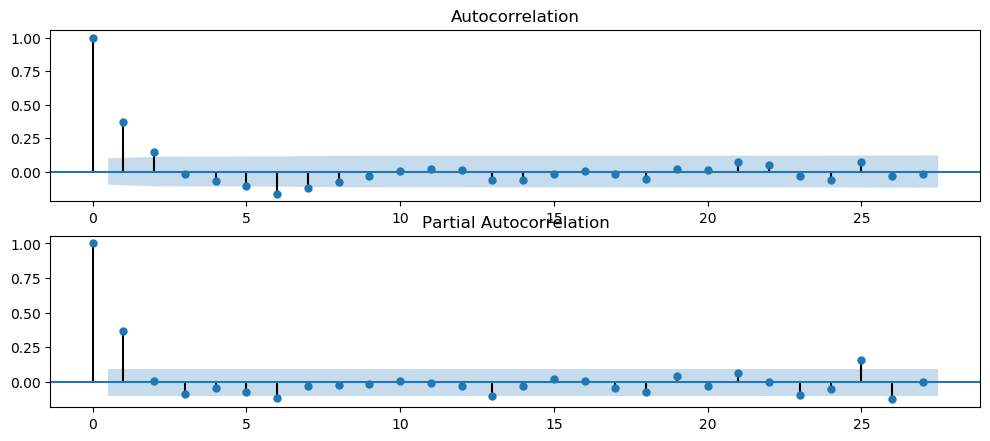

In [22]:
# find p and q values manually by plotting ACF and PACF graphs
plt.figure(figsize=(12,5), dpi=100)
pyplot.subplot(211)
plot_acf(data_final_univariate_differenced, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(data_final_univariate_differenced, ax=pyplot.gca())
pyplot.show()


#Interpretation:
#ACF plot suggests a good MA (q) term to be 0 or 1
#PACF plot suggests a good AR (p) term to be 0 or 1

In [23]:
#Try a random 1,1,0 ARIMA Model

model = ARIMA(data_final_univariate, order=(1,1,0)) #differencing is now achieved by setting d = 1 and not by taking the log
fitted = model.fit(disp=0)
print(fitted.summary())

#Interpretation: P-value of AR1 term is highly significant

                             ARIMA Model Results                              
Dep. Variable:                  D.WTI   No. Observations:                  403
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1149.720
Method:                       css-mle   S.D. of innovations              4.195
Date:                Tue, 07 Jul 2020   AIC                           2305.441
Time:                        19:34:30   BIC                           2317.438
Sample:                    11-30-1986   HQIC                          2310.190
                         - 05-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0519      0.333      0.156      0.876      -0.600       0.704
ar.L1.D.WTI     0.3728      0.047      8.001      0.000       0.282       0.464
                                    Roots       

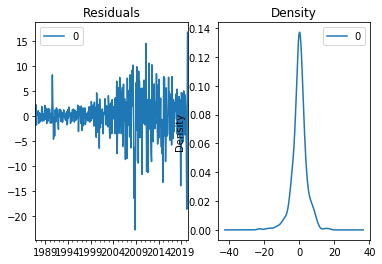

In [24]:
# Plot residual errors and density to check for patterns in model_fit 
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#Interpretation: the residual errors seem to fluctuate around a mean of zero and have a uniform variance

In [25]:
# compare manually found p,d,q values with auto_arima function given a forecasting period of 4 years (see train/test split below)

# Create Training and Test
train = data_final_univariate[1:356]
test = data_final_univariate[356:]

#build auto_arima function
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      max_m=10,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#Interpretation: Lowest AIC value is derived from (1,1,0) with significant p-values for both p and q

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1993.256, BIC=2008.733, Time=0.057 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2051.592, BIC=2059.331, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1991.817, BIC=2003.425, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2005.520, BIC=2017.128, Time=0.057 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2049.739, BIC=2053.608, Time=0.011 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1992.961, BIC=2008.438, Time=0.075 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1993.731, BIC=2013.077, Time=0.163 seconds
Total fit time: 0.434 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  355
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -992.909
Date:                Tue, 07 Jul 2020   AIC  

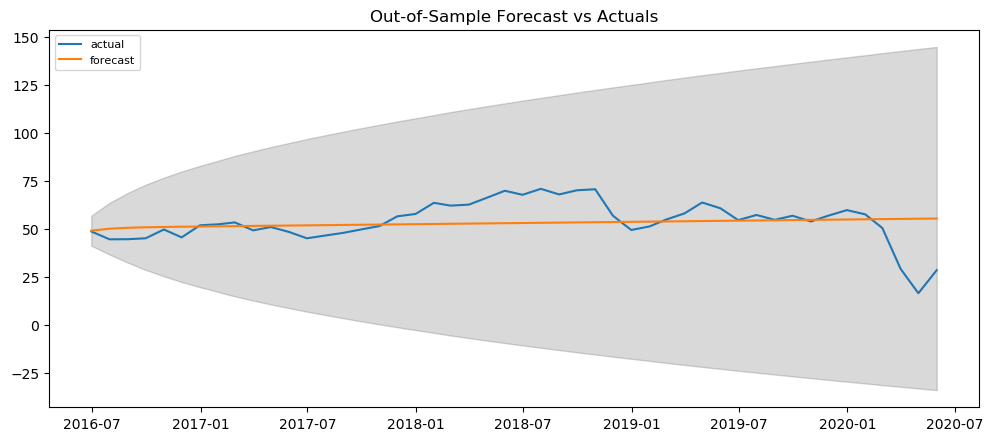

Out-of-Sample RMSE: 10.771


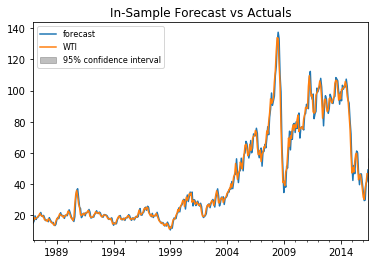

In_Sample RMSE: 1.748


In [26]:
#Out-of-Sample Forecast for the last 4 years of the dataset and comparison to actual values ###

# Build Model
# model = ARIMA(train, order=(1,1,0)) #trial/error discovers best result for given order
model = ARIMA(train, order=(1, 1, 0))  
fitted = model.fit(disp=False)  

# Forecast the last 24 months
fc, se, conf = fitted.forecast(48, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)

#plt.plot(train, label='training') #activate to see comparison with training data
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.plot(in_sample_predictions, label='in_sample') #activate to see comparison b/w training data and in_sample prediction
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Out-of-Sample Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Calculate RMSE of ARIMA out-of-sample model
mse = mean_squared_error(fc, test)
rmse = sqrt(mse)
ARIMA_Out_RMSE = rmse
print('Out-of-Sample RMSE: %.3f' % rmse)


# Actual vs Fitted for In-Sample
fitted.plot_predict(start=1, end=355, dynamic=False) #starting at 4 because dynamic=True requires k>AR term
plt.title('In-Sample Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

in_sample_predictions = fitted.predict(start=1, end=355, dynamic=False, typ='levels') # typ='levels'reverses Arima-based transformation
fc_seriesIn = pd.DataFrame(in_sample_predictions, index=train.index, columns = ['ARIMA_IN'])
fc_seriesOut = pd.DataFrame(fc_series, columns = ['ARIMA_OUT'])

# Calculate RMSE of In-Sample model
mse = mean_squared_error(train, in_sample_predictions)
rmse2 = sqrt(mse)
ARIMA_In_RMSE = rmse2
print('In_Sample RMSE: %.3f' % rmse2)

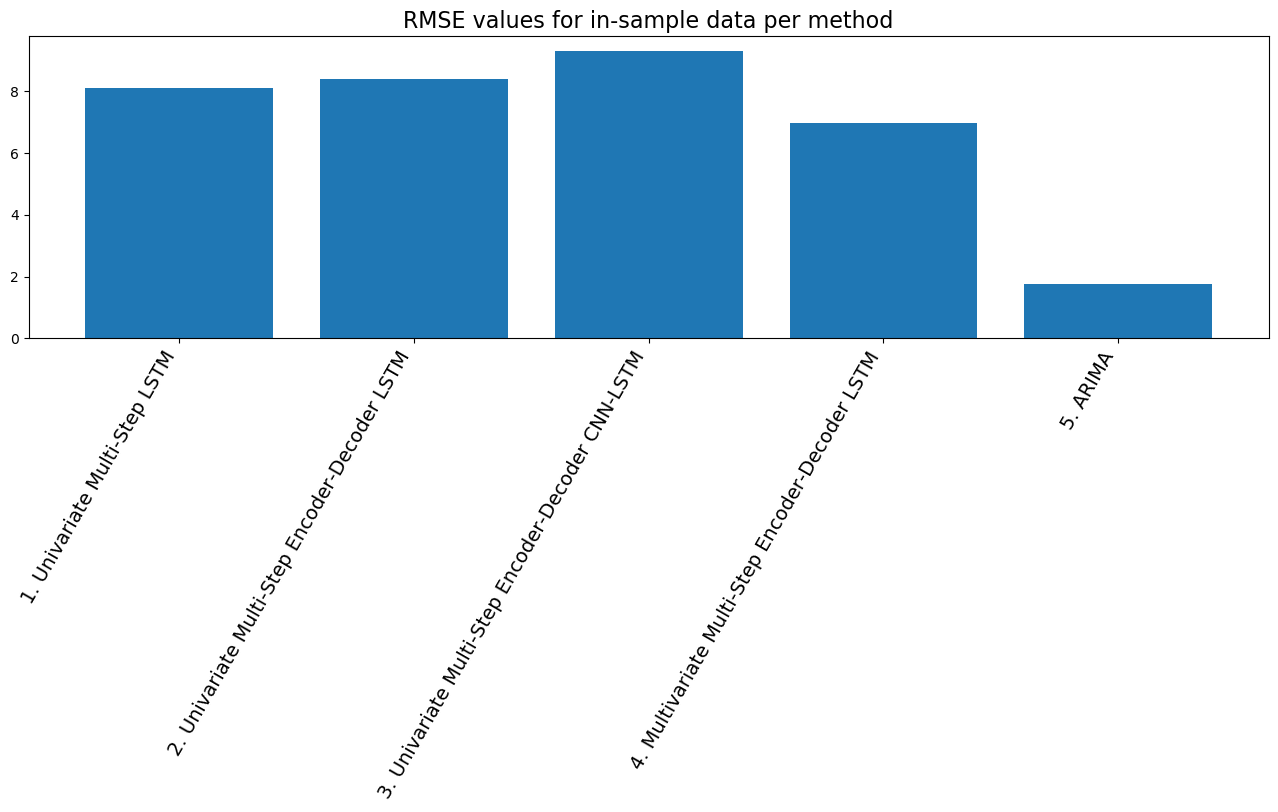

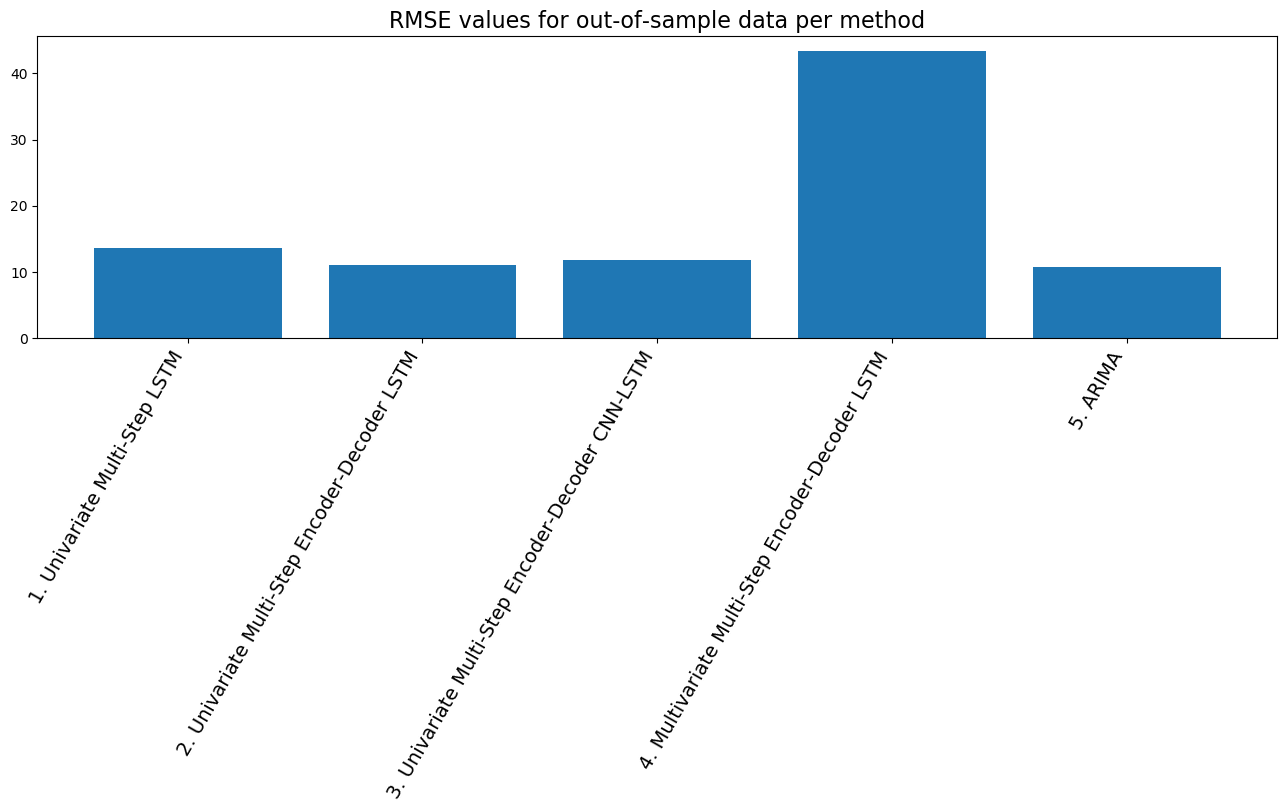

In [27]:
# Show and compare all RMSE values for each modul in a bar chart (In-sample, Out-of-Sample)
results_In = {
	'1. Univariate Multi-Step LSTM':RMSE_In_UnivariatesLSTM,
	'2. Univariate Multi-Step Encoder-Decoder LSTM':RMSE_In_UnivariatesEncDecLSTM,
	'3. Univariate Multi-Step Encoder-Decoder CNN-LSTM':RMSE_In_UnivariatesEncDecCNNLSTM,
	'4. Multivariate Multi-Step Encoder-Decoder LSTM':RMSE_In_MultivariatesEncDecLSTM,
	'5. ARIMA':ARIMA_In_RMSE}

results_Out = {
	'1. Univariate Multi-Step LSTM':RMSE_Out_UnivariatesLSTM,
	'2. Univariate Multi-Step Encoder-Decoder LSTM':RMSE_Out_UnivariatesEncDecLSTM,
	'3. Univariate Multi-Step Encoder-Decoder CNN-LSTM':RMSE_Out_UnivariatesEncDecCNNLSTM,
	'4. Multivariate Multi-Step Encoder-Decoder LSTM':RMSE_Out_MultivariatesEncDecLSTM,
	'5. ARIMA':ARIMA_Out_RMSE}

# plot in-sample RMSE comparison
plt.figure(figsize=(16,4), dpi=100)
pyplot.bar(results_In.keys(), results_In.values())
locs, labels = pyplot.xticks()
pyplot.setp(labels, rotation=60, ha='right', size = 14)
pyplot.title('RMSE values for in-sample data per method', size = 16)
pyplot.show()

# plot out of-sample RMSE comparison
plt.figure(figsize=(16,4), dpi=100)
pyplot.bar(results_Out.keys(), results_Out.values())
locs, labels = pyplot.xticks()
pyplot.setp(labels, rotation=60, ha='right', size = 14)
pyplot.title('RMSE values for out-of-sample data per method', size = 16)
pyplot.show()

In [28]:
#Preparation for the Plot for In-Sample and Out-Sample
df = pd.concat((data_plot_help, predictions_univariatesLSTM_IN,predictions_univariatesEncDecLSTM_In,predictions_univariatesEncDecCNNLSTM_In,predictions_multivariatesEncDecLSTM_In,fc_seriesIn), axis = 1)
df2= pd.concat((data_plot_help2, predictions_univariatesLSTM_Out,predictions_univariatesEncDecLSTM_Out,predictions_univariatesEncDecCNNLSTM_Out,predictions_multivariatesEncDecLSTM_Out, fc_seriesOut), axis = 1)

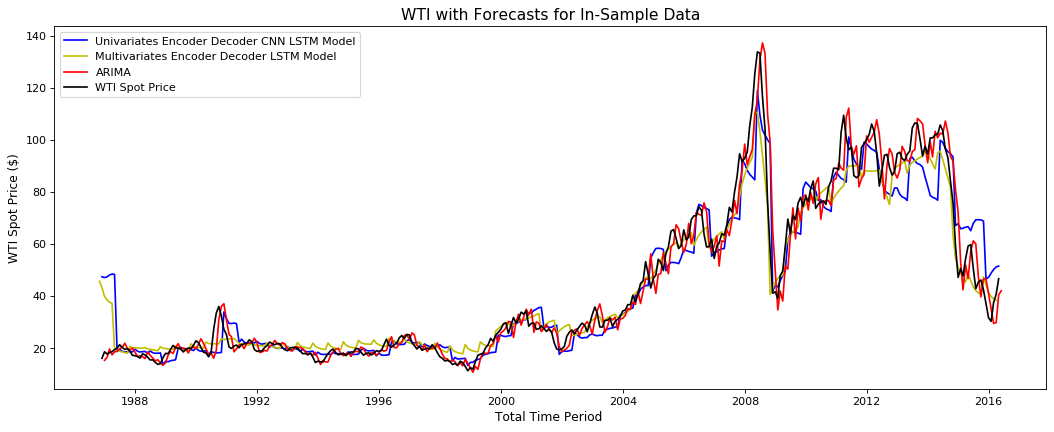

In [29]:
#All In-Sample FC plotted 
plt.figure(figsize=(16,6), dpi=80)
#two univariate models are outcommented due to clarity of the graphic
#plt.plot(df.index, df['Prediction_0'], label='Univariates LSTM Model')
#plt.plot(df.index, df['Prediction_1'], label='Univariates Encoder Decoder LSTM Model')
plt.plot(df.index, df['Prediction_2'], label='Univariates Encoder Decoder CNN LSTM Model',c = 'b')
plt.plot(df.index, df['Prediction_3'], label='Multivariates Encoder Decoder LSTM Model', c = 'y')
plt.plot(df.index, df['ARIMA_IN'], label='ARIMA', c='r')
plt.plot(df.index, df['WTI'], label='WTI Spot Price', c = 'k')
plt.ylabel('WTI Spot Price ($)', fontsize=11)
plt.xlabel('Total Time Period ', fontsize=11)
plt.title('WTI with Forecasts for In-Sample Data', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.show()

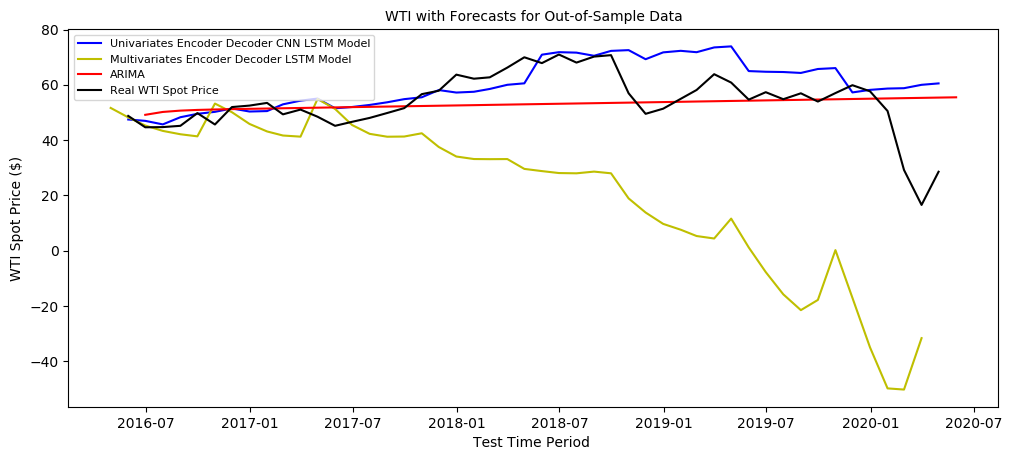

In [30]:
#All Out-of-Sample plotted
plt.figure(figsize=(12,5), dpi=100)
#two univariate models are outcommented due to clarity of the graphic
#plt.plot(df2.index, df2['Prediction_0'], label='Univariates LSTM Model')
#plt.plot(df2.index, df2['Prediction_1'], label='Univariates Encoder Decoder LSTM Model')
plt.plot(df2.index, df2['Prediction_2'], label='Univariates Encoder Decoder CNN LSTM Model', c = 'b')
plt.plot(df2.index, df2['Prediction_3'], label='Multivariates Encoder Decoder LSTM Model', c = 'y')
plt.plot(df2.index, df2['ARIMA_OUT'], label='ARIMA', c = 'r')
plt.plot(df2.index, df2['WTI'], label='Real WTI Spot Price', c = 'k')
plt.ylabel('WTI Spot Price ($)')
plt.xlabel('Test Time Period ')
plt.title('WTI with Forecasts for Out-of-Sample Data', fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.show()